In [1]:
from preprocess import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Function
from sklearn.model_selection import train_test_split

device = "cuda"

In [2]:
train_data_list = load_data2("train")
test_data_list = load_data2("test")

In [3]:
class FeatureExtractorEEG(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, padding=1),  # (32,8,9)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (64,8,9)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # (64,4,4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (128,4,4)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1))  # (128,1,1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # (batch, 128)
        return x

class FeatureExtratorEYE(nn.Module):
    def __init__(self, input_dim=33, hidden_dim1=256, hidden_dim2=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        return x


In [4]:
class MyClassifier(nn.Module):
    def __init__(self, extractor):
        super().__init__()
        self.extractor = extractor
        self.classifier = nn.Linear(128, 3)
    
    def forward(self, x):
        return self.classifier(self.extractor(x))


In [27]:
class DecisionFusion(nn.Module):
    def __init__(self, classifier_eeg, classifier_eye):
        super().__init__()
        self.classifier_eeg = classifier_eeg
        self.classifier_eye = classifier_eye
        for param in classifier_eeg.parameters(): param.requires_grad = False
        for param in classifier_eye.parameters(): param.requires_grad = False
        # self.w = nn.Parameter(torch.randn(1))
        self.w = 0.7

    def forward(self, x_eeg, x_eye):
        output_eeg = self.classifier_eeg(x_eeg)
        output_eye = self.classifier_eye(x_eye)
        output = self.w * output_eeg + (1-self.w) * output_eye
        return output

In [34]:
def train_classifier(model, X_train, Y_train, X_test, Y_test, batch_size=32, epochs=30, lr=1e-3):
    train_dataset = SeedDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    test_dataset = SeedDataset(X_test, Y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=4e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()

        correct_train = 0
        total_train = 0
        total_loss = 0  

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss

            pred = out.argmax(dim=1)
            correct_train += (pred == y).sum().item()
            total_train += y.size(0)


        train_acc = correct_train / total_train
        total_loss = total_loss / len(train_dataset)

        test_acc = get_acc1(model, test_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, loss = {total_loss:.4f} Test Acc: {test_acc:.4f}")
        
        if train_acc > 0.95: break

    print(f"final acc = {get_acc1(model, test_loader)}")

    return model

In [37]:
batch_size = 32
epochs = 30
# patience = 15

acc_list = []

for i in [2]:
# for i in range(12):

    X_EEG_train, X_EYE_train, Y_train = train_data_list[i]
    X_EEG_test, X_EYE_test, Y_test = test_data_list[i]

    eeg_scaler, X_EEG_train = fit_transform(X_EEG_train)
    X_EEG_test = transform(eeg_scaler, X_EEG_test)

    eye_scaler, X_EYE_train = fit_transform(X_EYE_train)
    X_EYE_test = transform(eye_scaler, X_EYE_test)

    train_dataset = FusionDataset(X_EEG_train, X_EYE_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    test_dataset = FusionDataset(X_EEG_test, X_EYE_test, Y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model_eeg = MyClassifier(FeatureExtractorEEG()).to(device)
    model_eye = MyClassifier(FeatureExtratorEYE()).to(device)

    model_eeg = train_classifier(model_eeg, X_EEG_train, Y_train, X_EEG_test, Y_test, lr=1e-4)
    model_eye = train_classifier(model_eye, X_EYE_train, Y_train, X_EYE_test, Y_test, epochs=100, lr=1e-3)

    model = DecisionFusion(model_eeg, model_eye).to(device)
    # optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=1e-4, weight_decay=4e-4)
    # criterion = nn.CrossEntropyLoss()

    # print(model.w)

    # last_w = float(model.w)
    
    # for epoch in range(epochs):
    #     model.train()

    #     correct_train = 0
    #     total_train = 0
    #     total_loss = 0  

    #     for x_eeg, x_eye, y in train_loader:
    #         x_eeg, x_eye, y = x_eeg.to(device), x_eye.to(device), y.to(device)
    #         optimizer.zero_grad()
    #         out = model(x_eeg, x_eye)
    #         loss = criterion(out, y)
    #         loss.backward()
    #         optimizer.step()

    #         total_loss += loss

    #         pred = out.argmax(dim=1)
    #         correct_train += (pred == y).sum().item()
    #         total_train += y.size(0)


    #     train_acc = correct_train / total_train
    #     total_loss = total_loss / len(train_dataset)

    #     test_acc = get_acc(model, test_loader)

    #     print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, loss = {total_loss:.4f} Test Acc: {test_acc:.4f}")
        
    #     if torch.abs(model.w - last_w) < 1e-4: break
    #     last_w = float(model.w)
    #     # print(f"w = {last_w}")

    # model.load_state_dict(best_model_state)
    # print(model.w)
    acc_list.append(get_acc(model, test_loader))
    print(f"acc {i} = {acc_list[-1]}")



Epoch 1/30, Train Acc: 0.3641, loss = 0.0342 Test Acc: 0.6414
Epoch 2/30, Train Acc: 0.5264, loss = 0.0313 Test Acc: 0.5938
Epoch 3/30, Train Acc: 0.6653, loss = 0.0297 Test Acc: 0.5938
Epoch 4/30, Train Acc: 0.6981, loss = 0.0285 Test Acc: 0.5928
Epoch 5/30, Train Acc: 0.7468, loss = 0.0275 Test Acc: 0.5938
Epoch 6/30, Train Acc: 0.7756, loss = 0.0266 Test Acc: 0.5957
Epoch 7/30, Train Acc: 0.8076, loss = 0.0258 Test Acc: 0.6346
Epoch 8/30, Train Acc: 0.8424, loss = 0.0251 Test Acc: 0.6764
Epoch 9/30, Train Acc: 0.8764, loss = 0.0244 Test Acc: 0.7036
Epoch 10/30, Train Acc: 0.9011, loss = 0.0238 Test Acc: 0.7094
Epoch 11/30, Train Acc: 0.9259, loss = 0.0232 Test Acc: 0.7036
Epoch 12/30, Train Acc: 0.9285, loss = 0.0226 Test Acc: 0.7153
Epoch 13/30, Train Acc: 0.9325, loss = 0.0221 Test Acc: 0.7143
Epoch 14/30, Train Acc: 0.9365, loss = 0.0216 Test Acc: 0.7123
Epoch 15/30, Train Acc: 0.9399, loss = 0.0211 Test Acc: 0.7065
Epoch 16/30, Train Acc: 0.9446, loss = 0.0207 Test Acc: 0.7026
E

[0.6666666666666666, 0.717201166180758, 0.6793002915451894, 0.771622934888241, 0.7968901846452867, 0.5947521865889213, 0.6248785228377065, 0.6015549076773566, 0.7803692905733722, 0.4868804664723032, 0.6462585034013606, 0.7337220602526725]
LOSO Mean Accuracy: 0.6750, Std: 0.0872


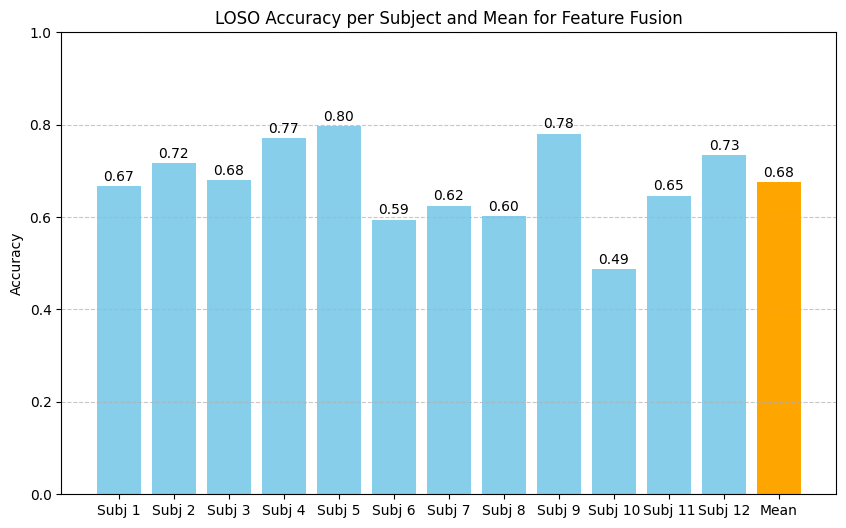

In [32]:
print(acc_list)
mean_acc = np.mean(acc_list)
std_acc = np.std(acc_list)
print(f"LOSO Mean Accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

x_labels = [f"Subj {i}" for i in range(1, 13)] + ["Mean"]
# 对应柱子高度
y_values = acc_list + [mean_acc]

# 绘制柱状图
plt.figure(figsize=(10,6))
bars = plt.bar(x_labels, y_values, color=['skyblue']*12 + ['orange'])

# 在柱子上显示数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("LOSO Accuracy per Subject and Mean for Feature Fusion")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

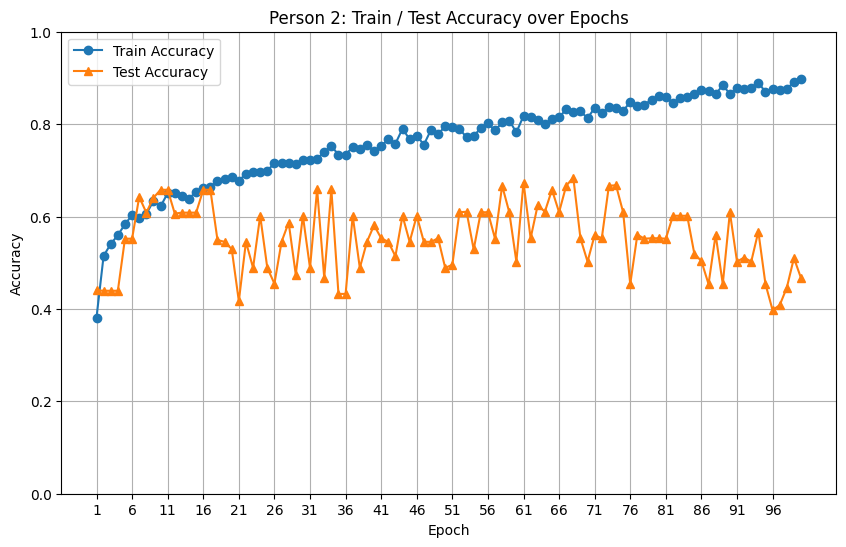

In [40]:
import matplotlib.pyplot as plt

# 训练准确率 (Train Acc)
train_acc = [
    0.3814, 0.5150, 0.5404, 0.5598, 0.5832, 0.6032, 0.5959, 0.6059, 0.6333, 0.6219,
    0.6506, 0.6513, 0.6446, 0.6386, 0.6540, 0.6607, 0.6647, 0.6760, 0.6814, 0.6860,
    0.6774, 0.6927, 0.6974, 0.6954, 0.6994, 0.7154, 0.7154, 0.7168, 0.7128, 0.7214,
    0.7214, 0.7248, 0.7401, 0.7522, 0.7341, 0.7341, 0.7502, 0.7462, 0.7555, 0.7408,
    0.7528, 0.7669, 0.7575, 0.7902, 0.7669, 0.7749, 0.7555, 0.7876, 0.7782, 0.7956,
    0.7943, 0.7896, 0.7715, 0.7742, 0.7916, 0.8016, 0.7862, 0.8036, 0.8076, 0.7822,
    0.8176, 0.8163, 0.8096, 0.8003, 0.8110, 0.8150, 0.8317, 0.8263, 0.8277, 0.8130,
    0.8350, 0.8230, 0.8363, 0.8343, 0.8283, 0.8484, 0.8383, 0.8424, 0.8530, 0.8604,
    0.8591, 0.8450, 0.8570, 0.8577, 0.8657, 0.8744, 0.8724, 0.8651, 0.8838, 0.8657,
    0.8784, 0.8758, 0.8791, 0.8898, 0.8697, 0.8758, 0.8737, 0.8764, 0.8911, 0.8978
]

# 测试准确率 (Test Acc)
test_acc = [
    0.4402, 0.4393, 0.4393, 0.4393, 0.5520, 0.5520, 0.6424, 0.6084, 0.6404, 0.6579,
    0.6579, 0.6064, 0.6084, 0.6084, 0.6084, 0.6579, 0.6579, 0.5491, 0.5452, 0.5296,
    0.4169, 0.5452, 0.4888, 0.6016, 0.4888, 0.4548, 0.5452, 0.5870, 0.4742, 0.6016,
    0.4888, 0.6589, 0.4674, 0.6589, 0.4325, 0.4325, 0.6016, 0.4888, 0.5452, 0.5811,
    0.5530, 0.5452, 0.5141, 0.6016, 0.5452, 0.6016, 0.5452, 0.5452, 0.5530, 0.4888,
    0.4956, 0.6093, 0.6103, 0.5287, 0.6093, 0.6093, 0.5520, 0.6667, 0.6093, 0.5024,
    0.6735, 0.5530, 0.6249, 0.6103, 0.6579, 0.6093, 0.6667, 0.6842, 0.5530, 0.5024,
    0.5598, 0.5530, 0.6667, 0.6676, 0.6093, 0.4538, 0.5607, 0.5520, 0.5530, 0.5530,
    0.5520, 0.6016, 0.6016, 0.6016, 0.5199, 0.5034, 0.4538, 0.5607, 0.4538, 0.6093,
    0.5024, 0.5112, 0.5024, 0.5675, 0.4538, 0.3975, 0.4082, 0.4461, 0.5102, 0.4665
]

# 构建 x 轴：1-base epoch
epochs = list(range(1, len(train_acc)+1))  # 1,2,...20

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, test_acc, marker='^', label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Person 2: Train / Test Accuracy over Epochs')
plt.xticks(range(1, len(train_acc)+1, 5))
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend()
plt.show()
